In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
from astropy.io import fits

import matplotlib.pyplot as plt

from utils import apply_random_rotation
from forward_model import forward, weight_map_w_redshift, add_shape_noise

In [2]:
path_cat = '/n17data/mkilbing/astro/data/CFIS/v1.0/SP_LFmask/unions_shapepipe_2022_v1.3_mtheli8k.fits'

cat_gal = fits.getdata(path_cat)

nside = 512

ra = cat_gal['RA']
dec = cat_gal['DEC']
e1 = cat_gal['e1']
e2 = cat_gal['e2']
w = cat_gal['w']

In [3]:
theta = (90 - dec) * np.pi / 180
phi = ra * np.pi / 180
pix = hp.ang2pix(nside, theta, phi, nest=False)

n_map = np.zeros(hp.nside2npix(nside))

unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)

n_map[unique_pix] += np.bincount(idx_rep, weights=w)

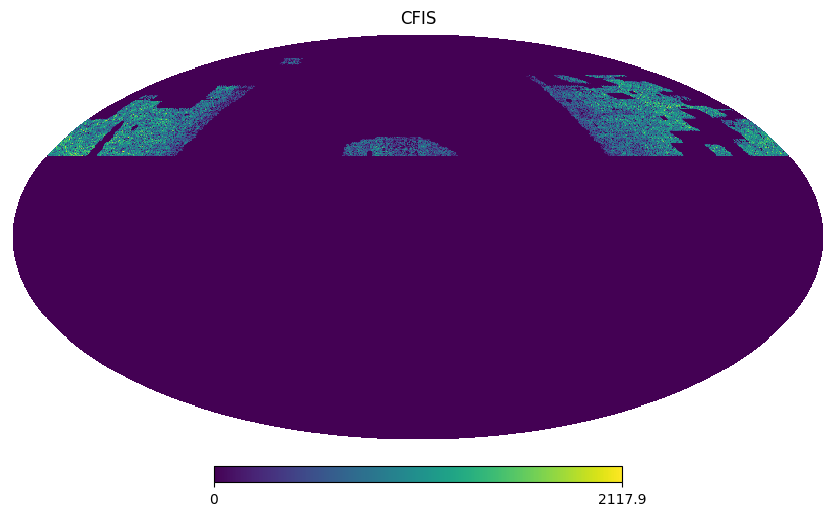

In [4]:
hp.mollview(n_map, nest=False, title='CFIS')
plt.show()

In [5]:
e1_rot, e2_rot = apply_random_rotation(e1, e2)

In [6]:
#generate the weak lensing map
path_info = '/n17data/sguerrini/GowerStreetSims/PKDGRAV3_on_DiRAC_DES_330 - Sheet1.csv'
path_sims = '/n17data/sguerrini/GowerStreetSims/'
sim_number = 1
nside = 512

kappa_lensing, kappa_ia, gamma, z_bin_edges = forward(path_sims, path_info, sim_number=1, nside=512, verbose=True, add_ia=False, A_ia=0.49, eta_ia=0.)

[!] Preprocessing the Gower Street simulation 1...
[!] Reading the cosmological parameters...
[!] Done in 2.55 min.
[!] Extracting overdensity maps and redshift edges for the Gower Street simulation 1...


100it [05:55,  3.55s/it]


[!] Done in 5.94 min.
[!] Number of redshift shells: 77
[!] Larger redshift: 2.07237
[!] Performing the ray tracing using GLASS...


100%|██████████| 77/77 [00:03<00:00, 21.15it/s]


[!] Converting convergence map to shear maps with lmax=1024...


100%|██████████| 77/77 [03:18<00:00,  2.58s/it]


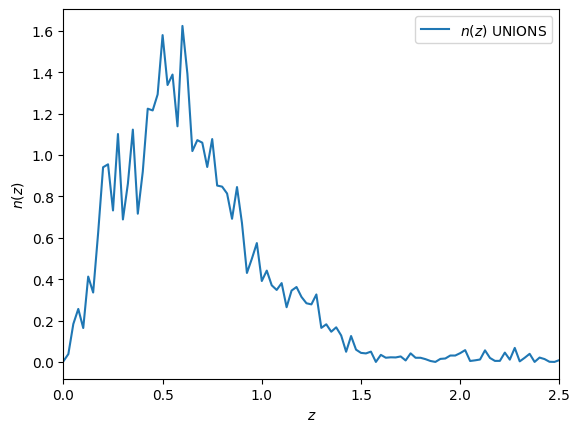

In [7]:
#Weight by UNIONS redshift distribution
path_dndz = '/n17data/mkilbing/astro/data/CFIS/v1.0/nz/dndz_SP_A.txt'

z, dndz = np.loadtxt(path_dndz, unpack=True)

plt.figure()

plt.plot(z, dndz, label=r'$n(z)$ UNIONS')

plt.xlabel(r'$z$')
plt.ylabel(r'$n(z)$')
plt.legend()

plt.xlim(0, 2.5)
plt.show()

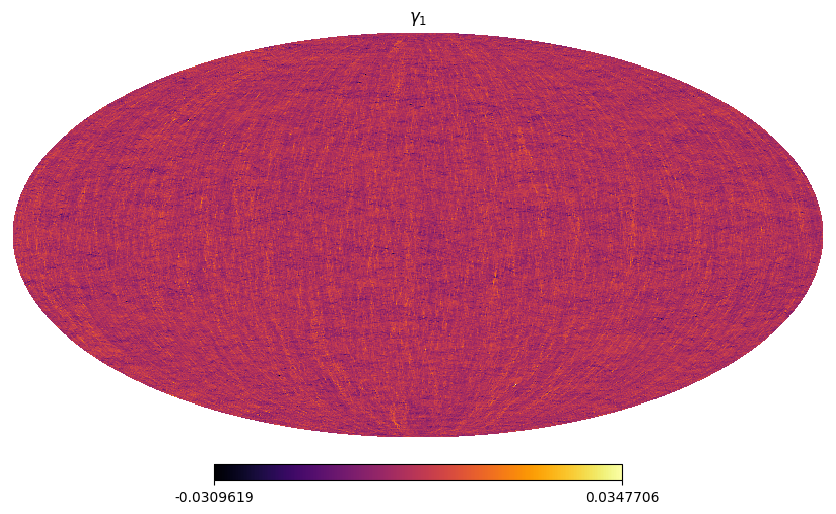

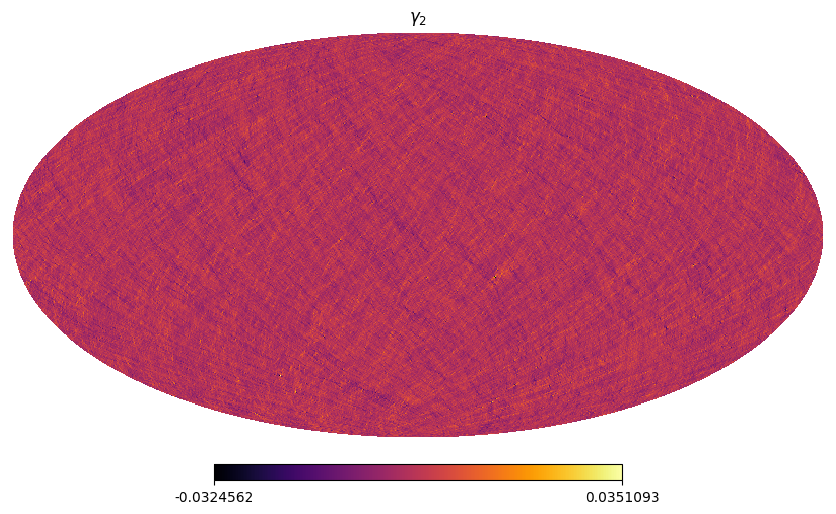

In [8]:
gamma_UNIONS = weight_map_w_redshift(gamma, z_bin_edges, (dndz, z))

hp.mollview(gamma_UNIONS.real, title=r'$\gamma_1$', cmap='inferno')
plt.show()

hp.mollview(gamma_UNIONS.imag, title=r'$\gamma_2$', cmap='inferno')
plt.show()

In [9]:
masked_shear_map, noise_map = add_shape_noise(gamma_UNIONS, ra, dec, e1, e2, w)

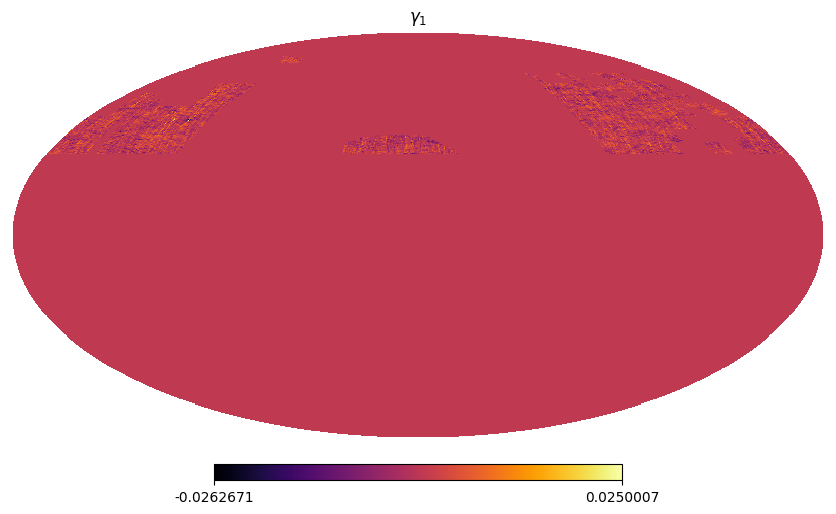

In [10]:
hp.mollview(masked_shear_map.real, title=r'$\gamma_1$', cmap='inferno')
plt.show()

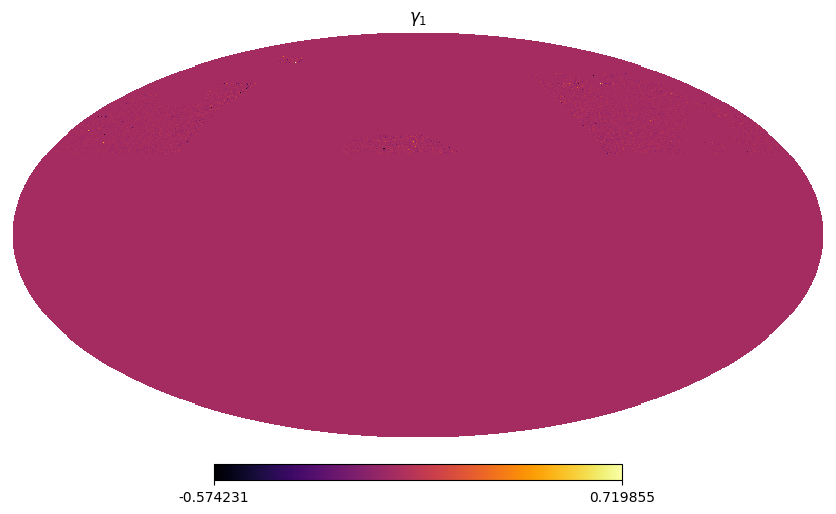

In [11]:
hp.mollview(masked_shear_map.real+noise_map.real, title=r'$\gamma_1$', cmap='inferno')
plt.show()

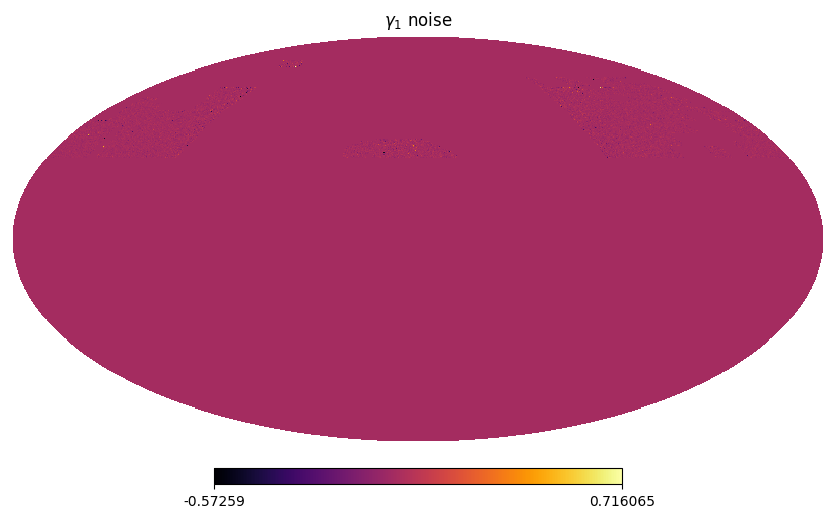

In [12]:
hp.mollview(noise_map.real, title=r'$\gamma_1$ noise', cmap='inferno')
plt.show()

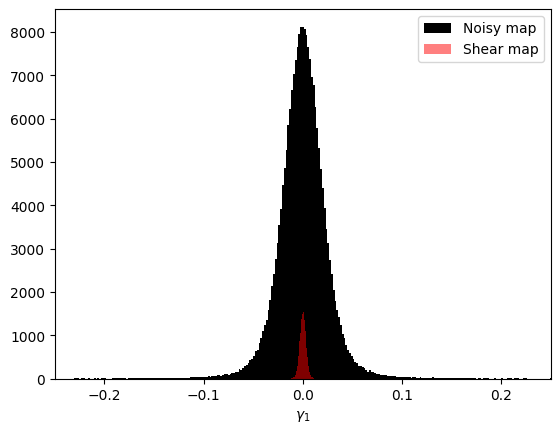

In [13]:
plt.figure()

plt.hist(noise_map.real[noise_map.real != 0], bins=1000, color='black', label='Noisy map')
plt.hist(masked_shear_map.real[masked_shear_map.real != 0], bins=1000, color='red', alpha=0.5, label='Shear map')

plt.legend()

plt.xlim(-0.25, 0.25)

plt.xlabel(r'$\gamma_1$')
plt.show()